# Parser for HWDDDA Project

In [1]:
#! pip install pandas
#! pip install matplotlib
#! pip install vectormath
#! pip install pyvista
#! pip install vtk
#! pip install scipy

#interactive plots
#%matplotlib notebook

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import vectormath as vmath
import pyvista as pv
from datetime import datetime, timedelta
import scipy.fftpack

import panel
panel.extension("vtk")
pv.set_plot_theme("document")

skiprows = 0 #used for ProcessData() to slide the start of the window

## LoadData() - read csv file and load it to a dataframe

Read the datafile and stick it in a data frame. Fixup a bunch of the data in the process (i.e. parse dates, calculate time per sample to interpolate the repeated timestamp blocks)

The data file starts with a calibration block (not currently parsing that calibration, just skipping it).

Since we have a bunch of data files, wrap this parsing into a function so we can cleanly call it once for each file.

Use either the stoprow or the rowcount. Stoprow takes precedence. This is meant to limit the loaded data, but still provide a workable dataset that can be diced up later and re-processed without reloading the whole file.

In [3]:
headerrowcount = 12
def LoadData(fname, startrow=0, stoprow=999999999999, rowcount=-1):
    filename = "../../data/preliminary/" + fname
    def f(s): #need to left pad the milliseconds
        if(len(s) != 21): #the string length (should) only vary by the last 3 characters, i.e. ms
            s = s[0:s.rfind(":")] + ":" + s[s.rfind(":")+1:].zfill(3)
        return pd.to_datetime(s, format="%m/%d/%y-%H:%M:%S:%f", errors="ignore")

    if rowcount > 0: #update the stoprow if we were passed a valid rowcount
        stoprow = startrow + rowcount
    
    #TODO: need to use readable column names to avoid confusion
    #pressure, temperature, voltage, accel1, accel2, accel3, strain gauge1, strain gauge2, strain gauge3
    headers = ["dt", "Sch", "Press", "Temp", "Volt", "AccX", "AccY", "AccZ", "Str1", "Str2", "Str3"]
    #headers = ["dt", "Sch", "Ch0", "Ch1", "Ch2", "Ch3", "Ch4", "Ch5", "Ch6", "Ch7", "Ch8"]#, "empty"]
    df = pd.read_csv(filename, 
                     header=None, names=headers, 
                     index_col=False, #deal with trailing comma shifting the columns
                     skiprows=headerrowcount+startrow,  #skip the calibration block for now
                     nrows=stoprow-startrow,
                     parse_dates=["dt"],
                     date_parser=f,
                     low_memory=False)
    
    #add a counter column for easy plotting. Keep the index so we can narrow the plots (i.e. use the x value to remap this function's start/stop row).
    #maintain the excel row number so that we can easily find it in the raw file
    excelstartrow = headerrowcount + startrow + 1
    df.insert(loc=0, column="cnt", value=np.arange(start=excelstartrow, stop=len(df)+excelstartrow))
    
    #add a column for the millisecond of the given sample
    #NOTE: this is not backwards validated... just the time from beginning to the end
    #TODO: this is slightly flawed in that the arbitrary start/stop daetime isnt the actual timestamp of that specific record (need to back up to the first of the repeated timestamp value)
    #TODO: better interpolation is done in the block below... should use that to get totalms (see column totalmsalt)
    #TODO: probably ditch this calc in favor of totalmsalt below.
    totalms = (df["dt"][len(df)-1] - df["dt"][0]).total_seconds() * 1000
    if np.isnan(totalms):
        print("ERROR: couldnt determine total milliseconds. Check input file.")
    else:
        mspersample = totalms / len(df)
        #print(mspersample)
        df.insert(loc=1, column="totalms", value=np.arange(start=0, stop=totalms, step=mspersample))
    
    #iterate to fixup the time per sample calculated. This is sloppy and slow, but should be functional enough
    #this calculates the time per sample and interpolates the wallclock timestamp for the repeated timestamps in a block
    mspersample = []
    fixedts = []
    basets = np.nan #holds the base timestamp, i.e. the first timestamp in a block
    nextts = np.nan #holds the next timestamp, i.e. the value of the next block
    countts = 0 #holds the number of repeated timestamps for the current block
    countcurr = 0
    for index, row in df.iterrows():
        #print(index, "-------")
        if basets != row["dt"]: #the current timestamp changed, so we need to update a bunch of things for this block
            basets = row["dt"] #update the current block's NEW timestamp
            countts = 0
            countcurr = 0
            #find the next timestamp and count the values
            for x in range(20): #limit to 20 to find the next new timestamp, just to bound the search
                dfindex = index + x
                if dfindex >= len(df): break #fell off the end
                
                if basets == df["dt"][dfindex]: #found a repeat
                    countts += 1 #count the repeated values (could also set to x)
                else: #found a new timestamp, so we're done
                    nextts = df["dt"][dfindex]
                    break
        else: #current timestamp didnt change, so just use the previously calculated values
            countcurr += 1
        msval = ((nextts - basets).total_seconds() * 1000) / countts
        mspersample.append(msval)
        fixedts.append(basets + timedelta(microseconds=(msval * 1000 * countcurr)))
        
    #this is probably a more accurate reading of the totalms compared to the method above
    df.insert(loc=2, column="totalmsalt", value=np.cumsum(mspersample)-mspersample[0]) #hack to shift all the values back to start at zero
    
    df.insert(loc=3, column="mspersample", value=mspersample)
    df.insert(loc=4, column="fixedts", value=fixedts)
    
    print("# of rows:", len(df))
    #print(df)
    #print(df.head(5))
    
    return(df)

## ProcessData() - Process the previously loaded dataframe into a new dataframe

Adds the following columns to a new dataframe (so we can reprocess the original without loading it back from disk): 

AccelCalibG[x/y/z]    AccelZeroedG[x/y/z]   Vel[x/y/z]

PosDelta[x/y/z] the change in position

Pos[x/y/z] the total position

In [4]:
def ProcessData(tmpdf, calib, skiprows=0, rowcount=99999999):
    dfcalib = df[skiprows:skiprows+rowcount].copy() #because we are going to dice up the dataframe, and we will likely want to re-process it
    print("Skipping", skiprows, "rows, starting at excel row #" + str(dfcalib["cnt"].iloc[0]), "---", dfcalib["dt"].iloc[0])
    
    #calibrate the values
    dfcalib["AccelCalibGX"] =  (df["AccX"] - calib["AccelZeroX"]) / calib["AccelGainX"]
    dfcalib["AccelCalibGY"] =  (df["AccY"] - calib["AccelZeroY"]) / calib["AccelGainY"]
    dfcalib["AccelCalibGZ"] =  (df["AccZ"] - calib["AccelZeroZ"]) / calib["AccelGainZ"]
    
    #Get the average over a larger swath (i.e. the full dataset loaded into df).
    calib["AccelMeanX"] = (df["AccX"].mean() - calib["AccelZeroX"]) / calib["AccelGainX"]
    calib["AccelMeanY"] = (df["AccY"].mean() - calib["AccelZeroY"]) / calib["AccelGainY"]
    calib["AccelMeanZ"] = (df["AccZ"].mean() - calib["AccelZeroZ"]) / calib["AccelGainZ"]
    
    #subtract off the mean to give zeroed calibrated G's with gravity removed
    dfcalib["AccelZeroedGX"] = dfcalib["AccelCalibGX"] - calib["AccelMeanX"]
    dfcalib["AccelZeroedGY"] = dfcalib["AccelCalibGY"] - calib["AccelMeanY"]
    dfcalib["AccelZeroedGZ"] = dfcalib["AccelCalibGZ"] - calib["AccelMeanZ"]
    
    #TODO: use the milliseconds per sample to calculate the actual velocity
    
    dfcalib["VelDeltaX"] = ((dfcalib["AccelZeroedGX"]+dfcalib["AccelZeroedGX"].shift(1))/2 * (dfcalib["mspersample"] / 1000) * 386.0886)
    dfcalib["VelDeltaY"] = ((dfcalib["AccelZeroedGY"]+dfcalib["AccelZeroedGY"].shift(1))/2 * (dfcalib["mspersample"] / 1000) * 386.0886)
    dfcalib["VelDeltaZ"] = ((dfcalib["AccelZeroedGZ"]+dfcalib["AccelZeroedGZ"].shift(1))/2 * (dfcalib["mspersample"] / 1000) * 386.0886)
    dfcalib["VelX"] = (dfcalib["VelDeltaX"]+calib["InitialVelX"]).cumsum()
    dfcalib["VelY"] = (dfcalib["VelDeltaY"]+calib["InitialVelY"]).cumsum()
    dfcalib["VelZ"] = (dfcalib["VelDeltaZ"]+calib["InitialVelZ"]).cumsum()
    
    dfcalib["PosDeltaX"] = dfcalib["VelX"] * dfcalib["mspersample"] / 1000
    dfcalib["PosDeltaY"] = dfcalib["VelY"] * dfcalib["mspersample"] / 1000
    dfcalib["PosDeltaZ"] = dfcalib["VelZ"] * dfcalib["mspersample"] / 1000
    dfcalib["PosX"] = dfcalib["PosDeltaX"].cumsum()
    dfcalib["PosY"] = dfcalib["PosDeltaY"].cumsum()
    dfcalib["PosZ"] = dfcalib["PosDeltaZ"].cumsum()
    
    return(dfcalib)

## PlotDataXXX() - Wrapper for some basic plotting.

In [5]:
def PlotDataRaw(_df, plotchannels):
    if(plotchannels == "accel"):
        _df.plot(kind="scatter", x="cnt", y="AccZ", title="Acc Z", color="green")
        plt.show()
        _df.plot(kind="scatter", x="cnt", y="AccX", title="Acc X", color="red")
        plt.show()
        _df.plot(kind="scatter", x="cnt", y="AccY", title="Acc Y", color="blue")
        plt.show()
    elif(plotchannels == "load"):
        _df.plot(kind="scatter", x="cnt", y="Str1", title="Strain 1 (Ch #6)", color="green")
        plt.show()
        _df.plot(kind="scatter", x="cnt", y="Str2", title="Strain 2 (Ch #7)", color="red")
        plt.show()
        _df.plot(kind="scatter", x="cnt", y="Str3", title="Strain 3 (Ch #8)", color="blue")
        plt.show()
    else:
        print("Ooops, plotchannels not supported:", plotchannels)

In [6]:
def PlotDataProcessed(_df, plotAll, vertline=None):
    if(plotAll == True):
        _df.plot(kind="scatter", x="cnt", y="VelZ", title="Velocity Z", color="green")
        plt.axhline(y=0, color="gray", linestyle="-")
        if(vertline != None): plt.axvline(x=vertline, color="gray", linestyle="-")
        plt.show()
    _df.plot(kind="scatter", x="cnt", y="PosZ", title="Position Z", color="green")
    plt.axhline(y=0, color="gray", linestyle="-")
    if(vertline != None): plt.axvline(x=vertline, color="gray", linestyle="-")
    plt.show()
    
    if(plotAll == True):
        _df.plot(kind="scatter", x="cnt", y="VelX", title="Velocity X", color="red")
        plt.axhline(y=0, color="gray", linestyle="-")
        if(vertline != None): plt.axvline(x=vertline, color="gray", linestyle="-")
        plt.show()
        _df.plot(kind="scatter", x="cnt", y="PosX", title="Position X", color="red")
        plt.axhline(y=0, color="gray", linestyle="-")
        if(vertline != None): plt.axvline(x=vertline, color="gray", linestyle="-")
        plt.show()    
    
        _df.plot(kind="scatter", x="cnt", y="VelY", title="Velocity Y", color="blue")
        plt.axhline(y=0, color="gray", linestyle="-")
        if(vertline != None): plt.axvline(x=vertline, color="gray", linestyle="-")
        plt.show()
        _df.plot(kind="scatter", x="cnt", y="PosY", title="Position Y", color="blue")
        plt.axhline(y=0, color="gray", linestyle="-")
        if(vertline != None): plt.axvline(x=vertline, color="gray", linestyle="-")
        plt.show()

## Actually load some data

Load data from the file. Only run one of these, or just make sure the last one is the one you want to use.

Try and get the start/stop row index to cover legitimate data (i.e. exclude bad startup and shutdown data if present).

We load the data here and then process it later so that we can operate on a subset of that data.

In [7]:
#df = LoadData("file_43_calibrated_20180516102829.csv") #this one has a bunch of empty values

In [8]:
#df = LoadData("File_18_1002_Calibrated_20190510135452.csv", 0, 100)

In [9]:
#df = LoadData("Thorman B-3/File_35_1002_Calibrated_20190801103404.csv", 8723, rowcount=5000)
#print(df)

calibration = {
    "AccelZeroX": 17288.88, #I'm not sure these are correct... See Lynn & Gabriel discussion.
    "AccelZeroY": 17217.23,
    "AccelZeroZ": 16897.29,
    
    "AccelGainX": 7314.35, 
    "AccelGainY": 7467.77, 
    "AccelGainZ": 7488.96,
    
    "AccelMeanX": np.nan, #update these in ProcessData()
    "AccelMeanY": np.nan,
    "AccelMeanZ": np.nan,
    
    "InitialVelX": 0, #the initial velocities should be zero, but it appears the bridle can wobble at BOS
    "InitialVelY": 0,
    "InitialVelZ": 0,
}

In [10]:
#calibration run
df = LoadData("File_29_1002_Calibrated_20200710150408.csv", 12400, 13200)

#dfprocessed = ProcessData(df, calibration, skiprows=n, rowcount=tmpRowCount)


# of rows: 800


## --------------------------
This is for the frequency analysis stuff on the load channels. A lot of the processing below this section was for calibration of the accelerometer

NOTE: this is on the unprocessed data (df)

TODO: find the optimal window for analysis

TODO: frequency analysis

In [11]:
df.describe() #get some stats from the original unprocessed data

cnt       totalms    totalmsalt  mspersample    Sch  \
count    800.0000    800.000000    800.000000   800.000000  800.0   
mean   12812.5000   6714.596250   6820.969375    16.807500    1.0   
std      231.0844   3883.951056   3919.192615    14.682304    0.0   
min    12413.0000      0.000000      0.000000   -60.307692    1.0   
25%    12612.7500   3357.298125   3424.096154    16.692308    1.0   
50%    12812.5000   6714.596250   6756.384615    16.692308    1.0   
75%    13012.2500  10071.894375  10888.769231    16.692308    1.0   
max    13212.0000  13429.192500  13337.500000   108.500000    1.0   

             Press          Temp         Volt          AccX          AccY  \
count   800.000000    800.000000   800.000000    800.000000    800.000000   
mean   1006.688750  17736.095000  7980.814213  17738.592500  17856.487500   
std       1.129588      1.630736     1.900096     11.222472     20.701704   
min    1001.000000  17728.000000  7976.910000  17666.000000  17728.000000   
25%    1006.000000  17736.000000  7978.440000  17733.000000  17845.000000   
50%    1007.000000  17736.000000  7982.540000  17740.000000  17857.000000   
75%    1008.000000  17736.000000  7982.540000  17745.000000  17868.000000   
max    1008.000000  17742.000000  7983.060000  17798.000000  17942.000000   

              AccZ          Str1          Str2          Str3  
count   800.000000    800.000000    800.000000    800.000000  
mean   9758.531250  10158.973750  11561.982500  10808.356250  
std       8.545045      5.206433      6.694828     18.503238  
min    9737.000000  10144.000000  11548.000000  10779.000000  
25%    9752.000000  10155.000000  11557.000000  10795.000000  
50%    9757.000000  10159.000000  11561.000000  10801.000000  
75%    9765.000000  10163.000000  11566.000000  10817.000000  
max    9808.000000  10173.000000  11591.000000  10858.000000

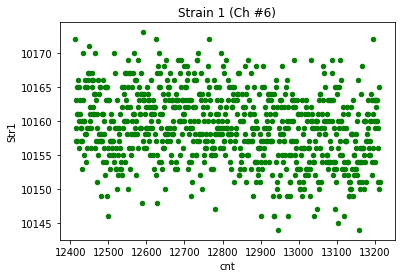

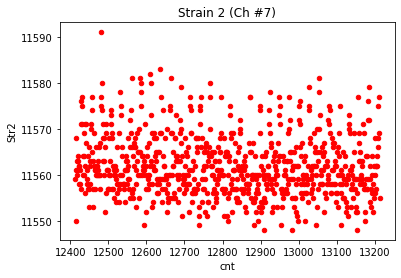

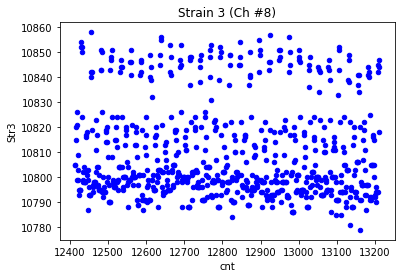

In [12]:
PlotDataRaw(df, "load")

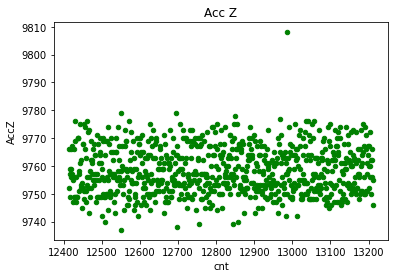

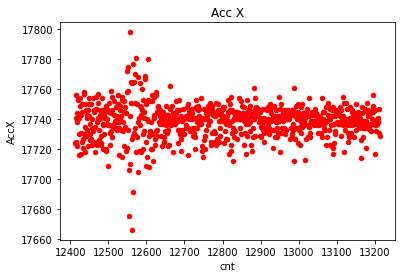

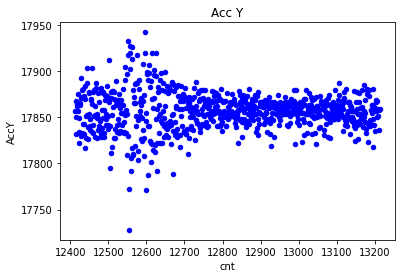

In [13]:
#maybe theres some mechanical vibration going on?
PlotDataRaw(df, "accel")

samples per second: 59.49724825226833 samples
seconds per sample: 0.0168075 seconds
sample range timespan: 13.446 seconds


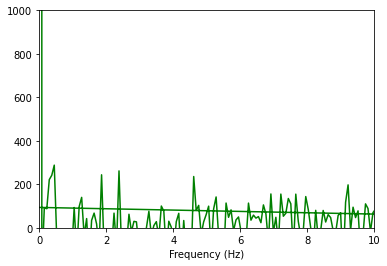

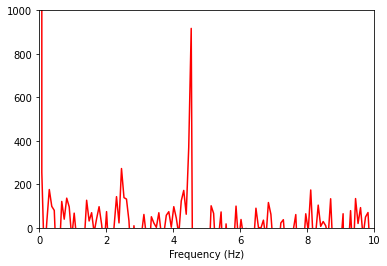

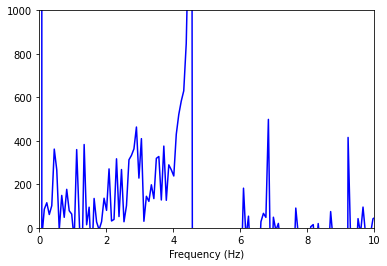

In [14]:
yf = scipy.fft.fft(df["Str1"].values)
freq = scipy.fft.fftfreq(len(yf), df["mspersample"].mean()/1000.0)

print("samples per second:", 1000.0/df["mspersample"].mean(), "samples")
print("seconds per sample:", df["mspersample"].mean()/1000.0, "seconds")
print("sample range timespan:", (df["mspersample"].mean()*len(yf))/1000.0, "seconds")

fig, ax = plt.subplots()
ax.plot(freq, yf.real, color="green")
ax.set_xlabel("Frequency (Hz)")
ax.set_xlim(0, 10)
ax.set_ylim(0, 1000)
plt.show()

yf = scipy.fft.fft(df["Str2"].values)
fig, ax = plt.subplots()
ax.plot(freq, yf.real, color="red")
ax.set_xlabel("Frequency (Hz)")
ax.set_xlim(0, 10)
ax.set_ylim(0, 1000)
plt.show()

yf = scipy.fft.fft(df["Str3"].values)
fig, ax = plt.subplots()
ax.plot(freq, yf.real, color="blue")
ax.set_xlabel("Frequency (Hz)")
ax.set_xlim(0, 10)
ax.set_ylim(0, 1000)
plt.show()

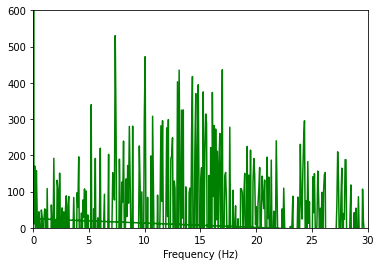

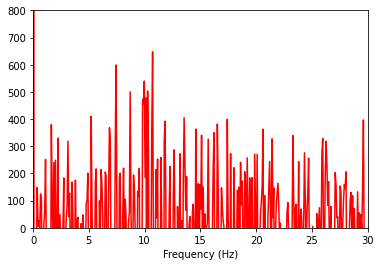

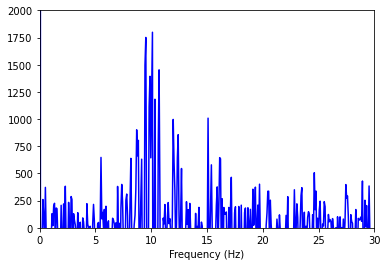

In [15]:
yf = scipy.fft.fft(df["AccZ"].values)
freq = scipy.fft.fftfreq(len(yf), df["mspersample"].mean()/1000.0)

fig, ax = plt.subplots()
ax.plot(freq, yf.real, color="green")
ax.set_xlabel("Frequency (Hz)")
ax.set_xlim(0, 30)
ax.set_ylim(0, 600)
plt.show()

yf = scipy.fft.fft(df["AccX"].values)
fig, ax = plt.subplots()
ax.plot(freq, yf.real, color="red")
ax.set_xlabel("Frequency (Hz)")
ax.set_xlim(0, 30)
ax.set_ylim(0, 800)
plt.show()

yf = scipy.fft.fft(df["AccY"].values)
fig, ax = plt.subplots()
ax.plot(freq, yf.real, color="blue")
ax.set_xlabel("Frequency (Hz)")
ax.set_xlim(0, 30)
ax.set_ylim(0, 2000)
plt.show()

## --------------------------
Stuff below here was for the accelerometer ===> position
## --------------------------

## Visually find the optimal start sample

Use this to plot a bunch of calcs from varying starting samples. You can then quickly scan the plots to find the one where the position returns to zero.

All the position plots start at zero on the left (because that is our "assumed" boundry condition), but in reality the mechanical system is not actually at zero. The plot that returns to zero at the right is "likely" to have picked the correct starting sample where the mechanical system was actually at zero.

Once you find a good starting row number, you can use the next cell to further narrow it down.

<span style="color:blue"><b>Key point:</b> Find the plot that crosses the zero line on the right side</span>.

Processing a window of 600 samples, sliding at incriments of 10 records
The first record in this data set is excel row #12413
Skipping 0 rows, starting at excel row #12413 --- 2020-07-10 14:33:28.232000


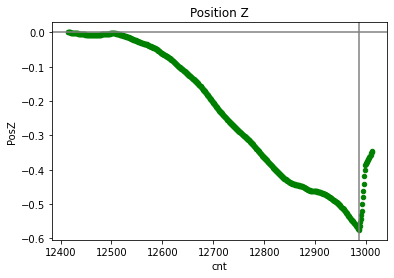

Skipping 10 rows, starting at excel row #12423 --- 2020-07-10 14:33:28.449000


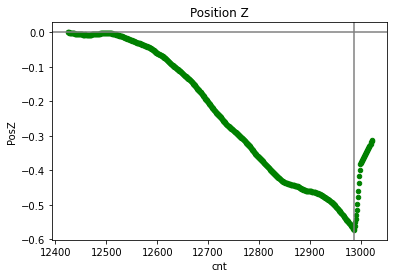

Skipping 20 rows, starting at excel row #12433 --- 2020-07-10 14:33:28.666000


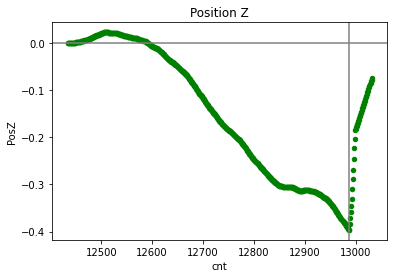

Skipping 30 rows, starting at excel row #12443 --- 2020-07-10 14:33:28.883000


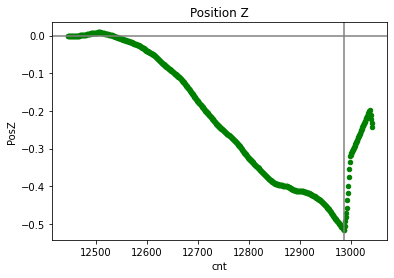

Skipping 40 rows, starting at excel row #12453 --- 2020-07-10 14:33:28.883000


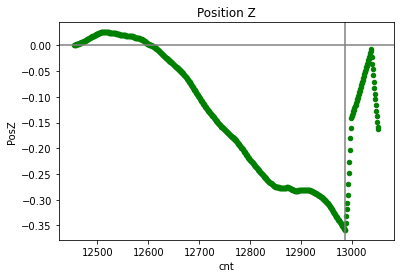

Skipping 50 rows, starting at excel row #12463 --- 2020-07-10 14:33:29.100000


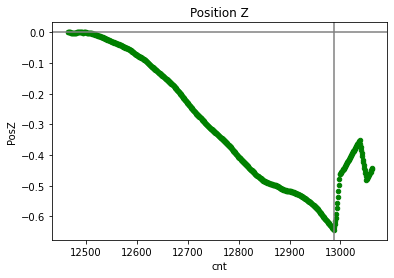

Skipping 60 rows, starting at excel row #12473 --- 2020-07-10 14:33:29.317000


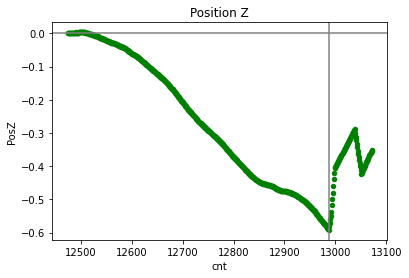

Skipping 70 rows, starting at excel row #12483 --- 2020-07-10 14:33:29.534000


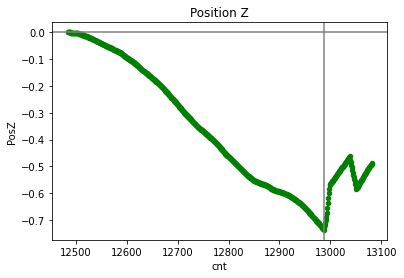

Skipping 80 rows, starting at excel row #12493 --- 2020-07-10 14:33:29.750000


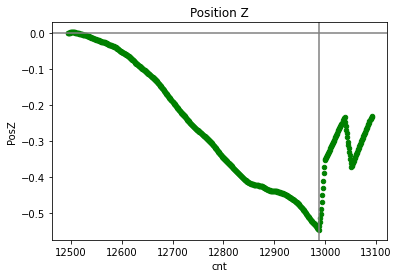

Skipping 90 rows, starting at excel row #12503 --- 2020-07-10 14:33:29.750000


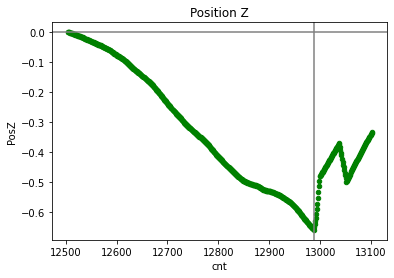

Skipping 100 rows, starting at excel row #12513 --- 2020-07-10 14:33:29.967000


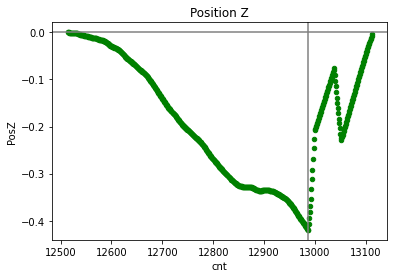

Skipping 110 rows, starting at excel row #12523 --- 2020-07-10 14:33:30.184000


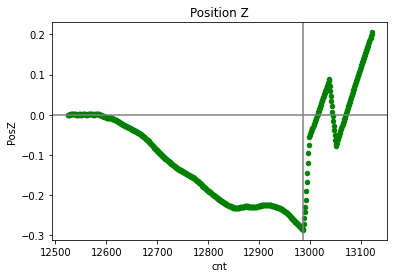

Skipping 120 rows, starting at excel row #12533 --- 2020-07-10 14:33:30.401000


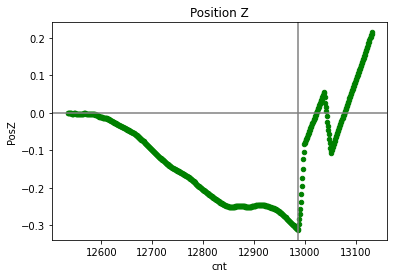

Skipping 130 rows, starting at excel row #12543 --- 2020-07-10 14:33:30.401000


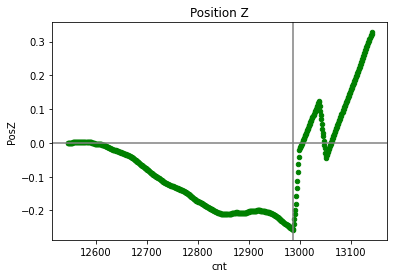

Skipping 140 rows, starting at excel row #12553 --- 2020-07-10 14:33:30.618000


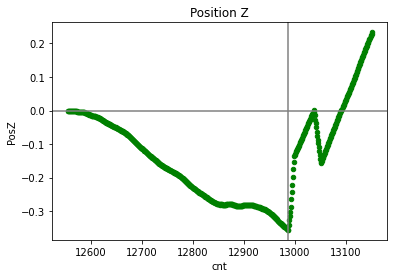

Skipping 150 rows, starting at excel row #12563 --- 2020-07-10 14:33:30.835000


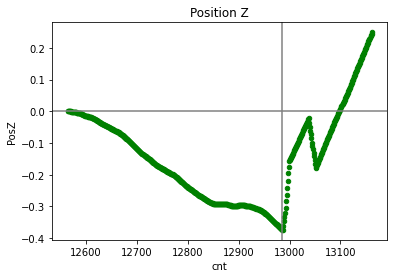

Skipping 160 rows, starting at excel row #12573 --- 2020-07-10 14:33:31.052000


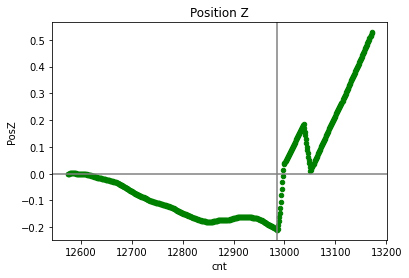

Skipping 170 rows, starting at excel row #12583 --- 2020-07-10 14:33:31.052000


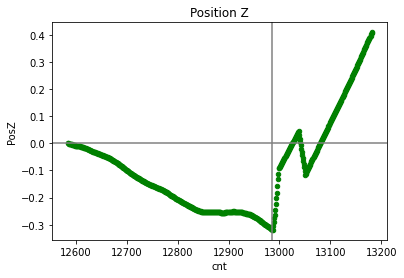

Skipping 180 rows, starting at excel row #12593 --- 2020-07-10 14:33:31.268000


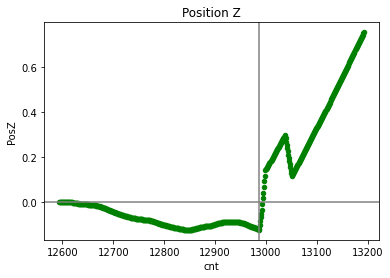

Skipping 190 rows, starting at excel row #12603 --- 2020-07-10 14:33:31.485000


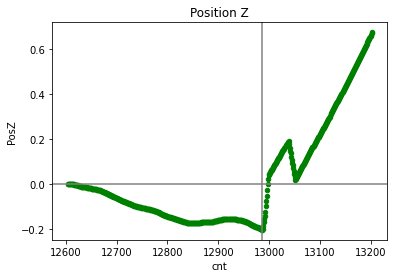

In [16]:
tmpStep = 10 #each plot will start at n*step
tmpLast = 200 #the last row where the plotting loop stops
tmpRowCount = 600 #make sure this spans at least one stroke

#NOTE: in this example, the plot returns to zero somewhere between 150 & 160 - see the plots below

print("Processing a window of", tmpRowCount, "samples, sliding at incriments of", tmpStep, "records")
print("The first record in this data set is excel row #" + str(df["cnt"].iloc[0]))

for n in range(0, tmpLast, tmpStep):
    dfprocessed = ProcessData(df, calibration, skiprows=n, rowcount=tmpRowCount)
    rightlocalminidx = dfprocessed["PosZ"].iloc[int(tmpRowCount/2):].idxmin()
    minvelcnt = dfprocessed["cnt"][rightlocalminidx]
    
    #check if the local minimum on the right isnt good. There are probably better methods for this (like it should follow the global maximum)
    if(rightlocalminidx == int(tmpRowCount/2)+n):
        minvelcnt = None
    
    PlotDataProcessed(dfprocessed, False, vertline=minvelcnt)

Skipping 153 rows, starting at excel row #12566 --- 2020-07-10 14:33:30.835000


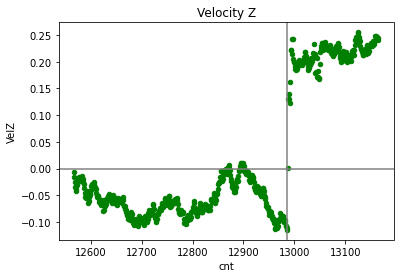

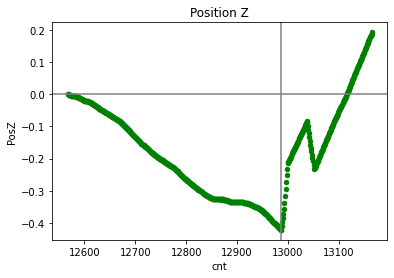

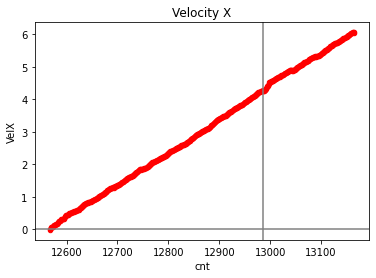

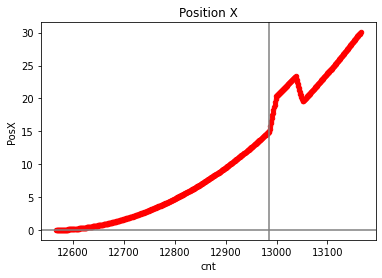

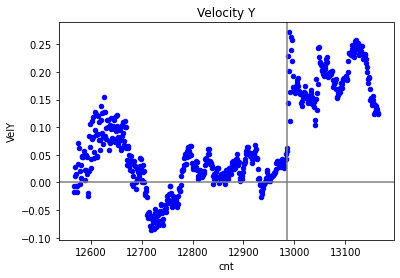

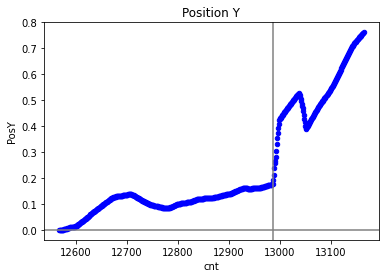

In [17]:
#in progress... calibrate & zero, then double integrate.

skiprows = 153 #found from the plots above
#skiprows += 1 #you could also re-run this same cell and incriment the skiprows each time (just a easy way to find the best fit)
#skiprows -= 1
rowcount = 600

#just playing around with non-zero lateral velocities at the start of the stroke
calibration["InitialVelX"] =  0.0100 #see the red plot below
calibration["InitialVelY"] = -0.0003 #see the blue plot below
calibration["InitialVelZ"] =  0 #obviously... we are trying to find the initial condition where Z is stopped

dfprocessed = ProcessData(df, calibration, skiprows=skiprows, rowcount=rowcount)

#get the localminima on the left half
rightlocalminidx = dfprocessed["PosZ"].iloc[int(rowcount/2):].idxmin()
minvelcnt = dfprocessed["cnt"][rightlocalminidx]
PlotDataProcessed(dfprocessed, True, vertline=minvelcnt)

In [18]:
dfprocessed.describe() #get some stats from the processed data. Checkout the max/min values for velocity & position

cnt       totalms    totalmsalt  mspersample    Sch  \
count    600.000000    600.000000    600.000000   600.000000  600.0   
mean   12865.500000   7605.393750   7727.186923    16.680641    1.0   
std      173.349358   2913.569339   2979.480032    16.034211    0.0   
min    12566.000000   2571.547500   2644.730769   -60.307692    1.0   
25%    12715.750000   5088.470625   5142.403846    16.692308    1.0   
50%    12865.500000   7605.393750   7640.346154    16.692308    1.0   
75%    13015.250000  10122.316875  10915.961538    16.692308    1.0   
max    13165.000000  12639.240000  12636.423077    93.615385    1.0   

             Press          Temp        Volt          AccX          AccY  ...  \
count   600.000000    600.000000   600.00000    600.000000    600.000000  ...   
mean   1006.708333  17735.886667  7980.82640  17738.638333  17856.673333  ...   
std       1.096327      0.891710     1.89777      9.929343     18.391947  ...   
min    1003.000000  17729.000000  7976.91000  17691.000000  17771.000000  ...   
25%    1006.000000  17736.000000  7978.44000  17733.000000  17847.000000  ...   
50%    1007.000000  17736.000000  7982.54000  17740.000000  17858.000000  ...   
75%    1008.000000  17736.000000  7982.54000  17745.000000  17867.000000  ...   
max    1008.000000  17742.000000  7983.06000  17781.000000  17942.000000  ...   

        VelDeltaZ        VelX        VelY        VelZ   PosDeltaX   PosDeltaY  \
count  599.000000  599.000000  599.000000  599.000000  599.000000  599.000000   
mean     0.000401    3.061823    0.073786    0.021375    0.050186    0.001272   
std      0.010023    1.759936    0.085907    0.128478    0.079094    0.003524   
min     -0.038761   -0.014312   -0.085766   -0.114864   -0.299990   -0.014766   
25%     -0.004330    1.535592    0.013048   -0.076179    0.023296    0.000185   
50%     -0.000457    3.004577    0.045815   -0.044993    0.048155    0.000716   
75%      0.004276    4.685327    0.150168    0.197146    0.078209    0.002427   
max      0.130159    6.068756    0.271607    0.255249    0.424638    0.025427   

        PosDeltaZ        PosX        PosY        PosZ  
count  599.000000  599.000000  599.000000  599.000000  
mean     0.000323   10.524357    0.233538   -0.174416  
std      0.003686    9.331191    0.208212    0.144065  
min     -0.014115   -0.000239   -0.000389   -0.422003  
25%     -0.001309    2.021291    0.101036   -0.318077  
50%     -0.000828    7.673009    0.132733   -0.177354  
75%      0.003291   20.481337    0.428604   -0.062765  
max      0.022766   30.061691    0.762029    0.193282  

[8 rows x 32 columns]

In [19]:
df.describe() #get some stats from the original unprocessed data

cnt       totalms    totalmsalt  mspersample    Sch  \
count    800.0000    800.000000    800.000000   800.000000  800.0   
mean   12812.5000   6714.596250   6820.969375    16.807500    1.0   
std      231.0844   3883.951056   3919.192615    14.682304    0.0   
min    12413.0000      0.000000      0.000000   -60.307692    1.0   
25%    12612.7500   3357.298125   3424.096154    16.692308    1.0   
50%    12812.5000   6714.596250   6756.384615    16.692308    1.0   
75%    13012.2500  10071.894375  10888.769231    16.692308    1.0   
max    13212.0000  13429.192500  13337.500000   108.500000    1.0   

             Press          Temp         Volt          AccX          AccY  \
count   800.000000    800.000000   800.000000    800.000000    800.000000   
mean   1006.688750  17736.095000  7980.814213  17738.592500  17856.487500   
std       1.129588      1.630736     1.900096     11.222472     20.701704   
min    1001.000000  17728.000000  7976.910000  17666.000000  17728.000000   
25%    1006.000000  17736.000000  7978.440000  17733.000000  17845.000000   
50%    1007.000000  17736.000000  7982.540000  17740.000000  17857.000000   
75%    1008.000000  17736.000000  7982.540000  17745.000000  17868.000000   
max    1008.000000  17742.000000  7983.060000  17798.000000  17942.000000   

              AccZ          Str1          Str2          Str3  
count   800.000000    800.000000    800.000000    800.000000  
mean   9758.531250  10158.973750  11561.982500  10808.356250  
std       8.545045      5.206433      6.694828     18.503238  
min    9737.000000  10144.000000  11548.000000  10779.000000  
25%    9752.000000  10155.000000  11557.000000  10795.000000  
50%    9757.000000  10159.000000  11561.000000  10801.000000  
75%    9765.000000  10163.000000  11566.000000  10817.000000  
max    9808.000000  10173.000000  11591.000000  10858.000000

## ------------------------------ DONE -----------------------------------------------

Everything below here is just experimentation (well, I suppose the whole thing is... this is just leftover code for now)

Now we can plot the data. matplotlib is a bit more interactive when run locally, but this should be good enough for now.
Just plot the individual components to get an overview.

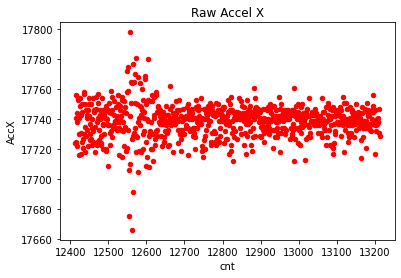

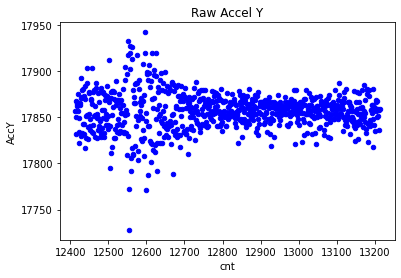

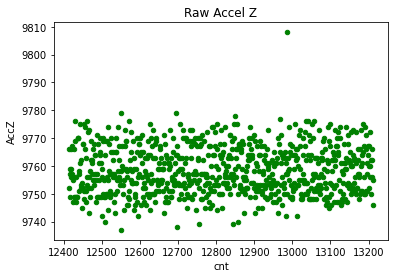

In [20]:
df.plot(kind="scatter", x="cnt", y="AccX", title="Raw Accel X", color="red")
plt.show()
df.plot(kind="scatter", x="cnt", y="AccY", title="Raw Accel Y", color="blue")
plt.show()
df.plot(kind="scatter", x="cnt", y="AccZ", title="Raw Accel Z", color="green")
plt.show()

TODO: Fix this stuff below

Lets get the gravity vector now. This should also be the direction of tool travel. Ideally, the samples that are not part of normal motion should have been eliminated above, and we should have enough samples to wash out partial strokes at the beginning/end.

In [21]:
gravityv = vmath.Vector3(df["AccX"].mean(), df["AccY"].mean(), df["AccZ"].mean())
print("Gravity vector:", gravityv)

#not sure if these next few lines are needed....

#I suck at python, but this should be an array of x,y,z vectors
arrxyz = np.reshape((np.array(df["AccX"]), np.array(df["AccY"]), np.array(df["AccZ"])), (3, -1)).transpose()


#load them into a Vector3Array to operate on
v_array = vmath.Vector3Array(arrxyz)

Gravity vector: [17738.5925  17856.4875   9758.53125]


Give a 3D view of that gravity vector... should roughly indicate the orientation of the tool.

In [22]:
pg = pv.Plotter()
pg.set_background("gray")
veczero = np.array([0., 0., 0.])

#TODO: probably want to orient these so direction of travel is up/down on this plot
vecgrav = np.array([calibration["AccelMeanX"], calibration["AccelMeanY"], calibration["AccelMeanZ"]])
gravline = np.stack((veczero, vecgrav))
_ = pg.add_lines(gravline, color="red") #notebook doesnt like line colors

#print("Average vector (represents gravity):", vecgrav)

#because I cant figure out how to plot the proper grid in pyvista. This is a bit hacky.
vertline = np.stack((veczero, np.array([0., 0., 1.])))
_ = pg.add_lines(vertline, color="blue")

horiline = np.stack((np.array([-1., 0., 0.]), np.array([1., 0., 0.])))
_ = pg.add_lines(horiline, color="blue")

horiline = np.stack((np.array([0., -1., 0.]), np.array([0., 1., 0.])))
_ = pg.add_lines(horiline, color="green")

#_ = pg.add_axes(interactive=True, color="blue") #notebook doesnt render helper
_ = pg.show_bounds(grid="front", location="outer", all_edges=True, color="red")
#_ = pg.show_grid() #not working?

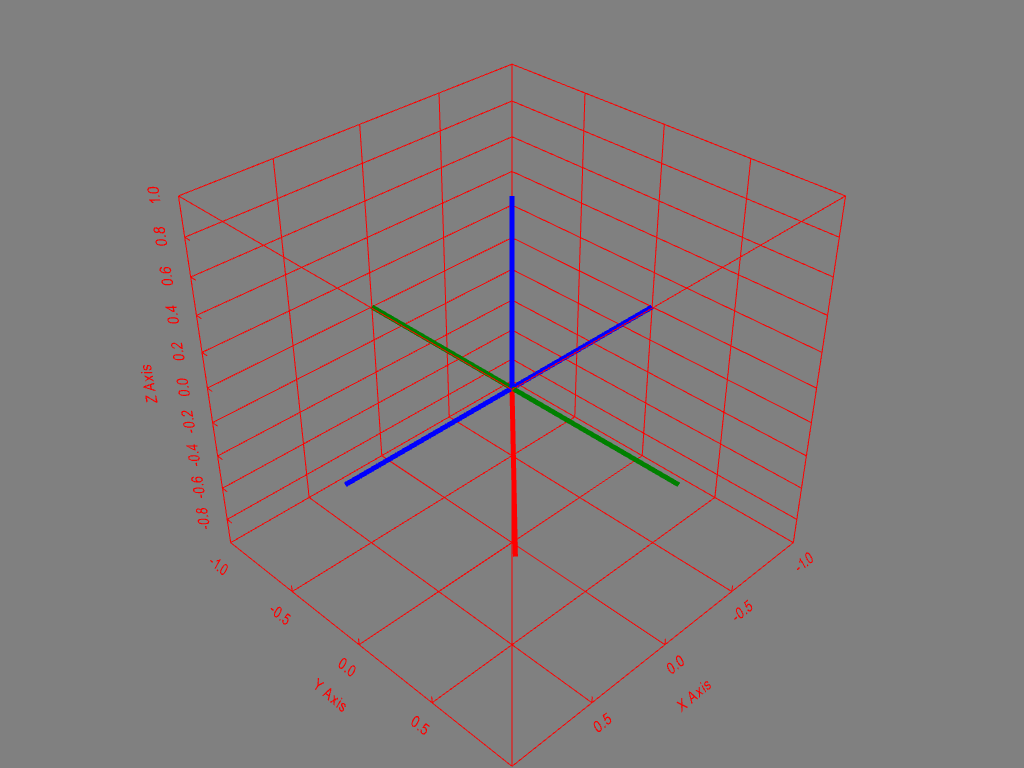

In [23]:
#this should show the orientation relative to true vertical. This could be due to misalignment or incorrect/incomplete average.
pg.show()

## TODO: should apply calibration to the raw sample data

Just plot all acceleration samples. Not too helpful at this point.

In [24]:
p = pv.Plotter()
p.set_background("gray")

verts = np.column_stack((df["AccX"], df["AccY"], df["AccZ"]))
_ = p.add_points(verts, color="red")
_ = p.add_axes()

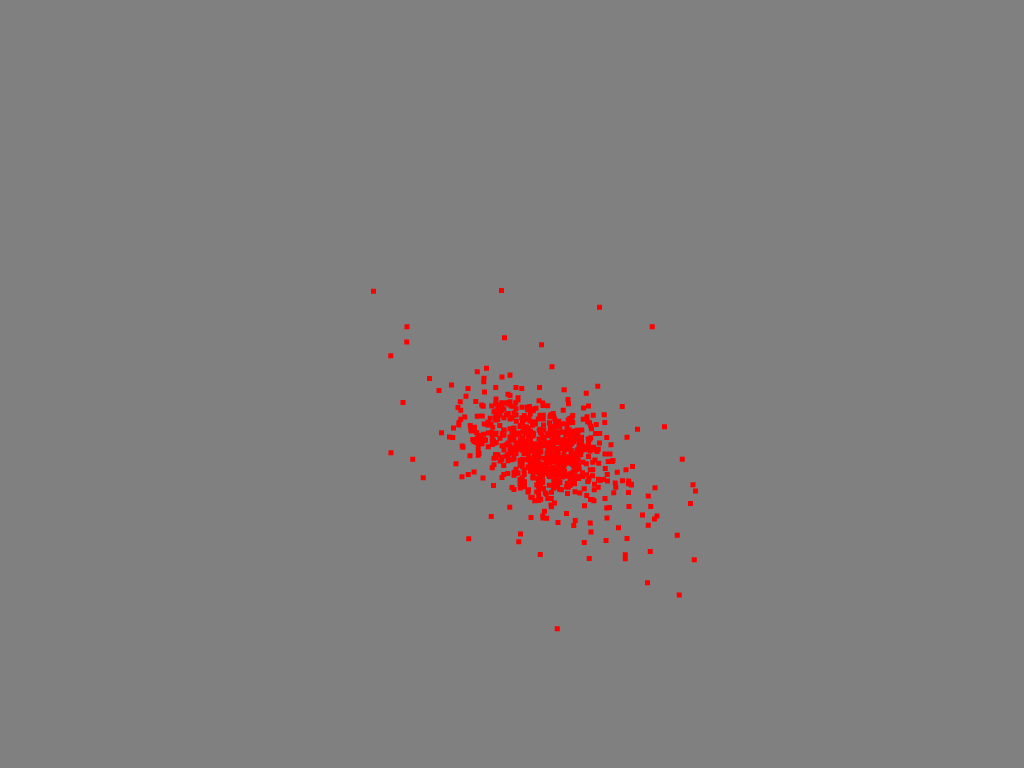

In [25]:
p.show()

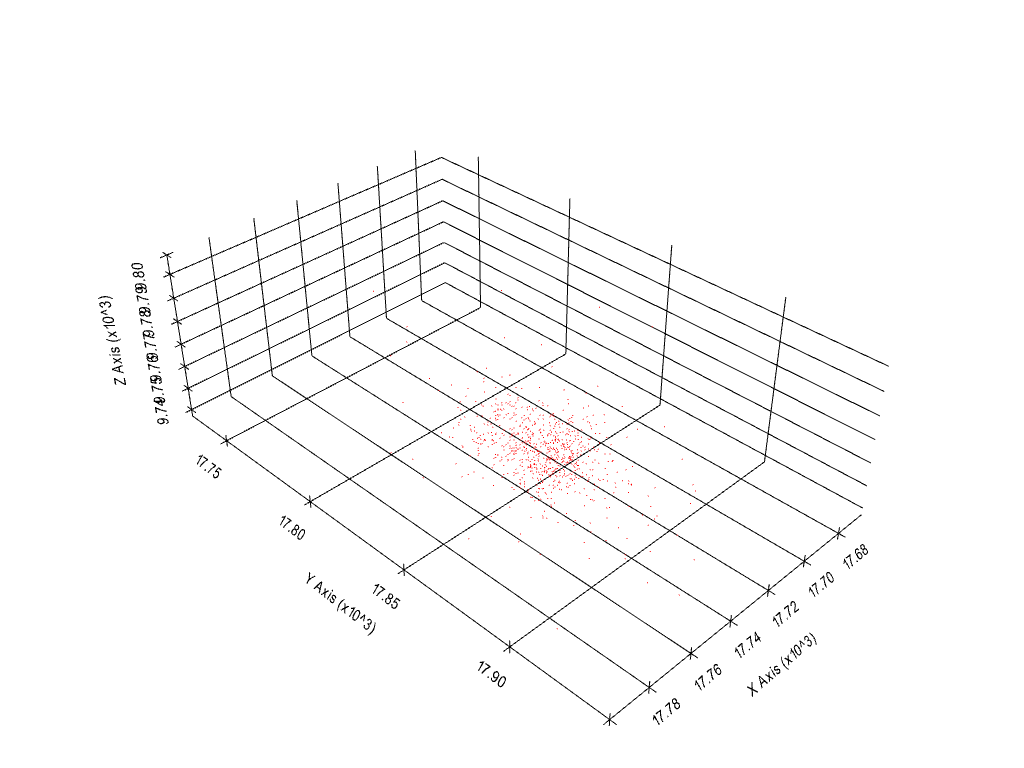

In [26]:
pc = pv.PolyData(verts)
pc.plot(point_size=1, show_grid=True, color="red")

In [27]:
print("test")

test
